In [1]:
# Однозначная многоклассовая классификация (На основе темы новостных лент)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import reuters
from keras import models, layers, losses, metrics, optimizers

In [7]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000) # num_words - получаем это колич слов (наиболее встречаемых)
# data - лист с индексами слов
# labels - метка класса текста 0..45


In [8]:
len(train_data), len(test_data)

(8982, 2246)

In [9]:
# Пример расшифровки
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_review

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [10]:
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results

x_train = vectorize_sequences(train_data)  # векторизованные обучающие данные
x_test = vectorize_sequences(test_data) # ветризованные тестовые данные

In [30]:
# веторизуем метки

# One hot encoding (Прямое кодирование) - вектор с нулевыми эл-ми со зн-нием 1 в эл-те, индекс которого
# соответствует индексу метки
def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
  return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

# Аналогичная системная реализация
#from keras.utils.np_utils import to_categorical
#one_hot_train_labels = to_categorical(train_labels)
#one_hot_test_labels = to_categorical(test_labels)

In [31]:
# модель
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=[metrics.categorical_accuracy])

In [32]:
# Валидацияонный набор (проверка точности во время обучения)
x_validation = x_train[:1000]
partial_x_train = x_train[1000:]

y_validation = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [33]:
history = model.fit(x=partial_x_train, y=partial_y_train, epochs=9, batch_size=512, validation_data=(x_validation, y_validation))

Epoch 1/9
16/16 [==============================] - 1s 50ms/step - loss: 2.5300 - categorical_accuracy: 0.5158 - val_loss: 1.7019 - val_categorical_accuracy: 0.6230
Epoch 2/9
16/16 [==============================] - 1s 43ms/step - loss: 1.3861 - categorical_accuracy: 0.6989 - val_loss: 1.3157 - val_categorical_accuracy: 0.7220
Epoch 3/9
16/16 [==============================] - 1s 43ms/step - loss: 1.0353 - categorical_accuracy: 0.7784 - val_loss: 1.1350 - val_categorical_accuracy: 0.7580
Epoch 4/9
16/16 [==============================] - 1s 42ms/step - loss: 0.8152 - categorical_accuracy: 0.8266 - val_loss: 1.0405 - val_categorical_accuracy: 0.7690
Epoch 5/9
16/16 [==============================] - 1s 42ms/step - loss: 0.6427 - categorical_accuracy: 0.8661 - val_loss: 0.9599 - val_categorical_accuracy: 0.7990
Epoch 6/9
16/16 [==============================] - 1s 42ms/step - loss: 0.5093 - categorical_accuracy: 0.8980 - val_loss: 0.9141 - val_categorical_accuracy: 0.8060
Epoch 7/9
16/16 

In [36]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


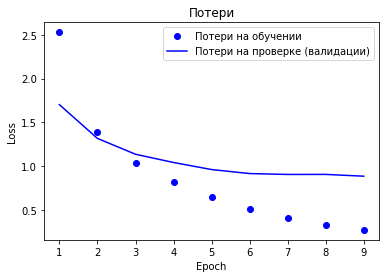

In [34]:
# График потерь
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epoch = range(1, len(loss_values) + 1)

plt.plot(epoch, loss_values, 'bo', label='Потери на обучении')
plt.plot(epoch, val_loss_values, 'b', label='Потери на проверке (валидации)')
plt.title('Потери')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend()
plt.show()

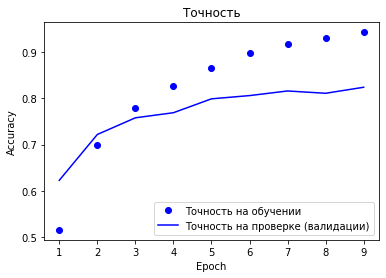

In [37]:
# График точности
acc_values = history_dict['categorical_accuracy']
val_acc_values = history_dict['val_categorical_accuracy']

epoch = range(1, len(loss_values) + 1)

plt.plot(epoch, acc_values, 'bo', label='Точность на обучении')
plt.plot(epoch, val_acc_values, 'b', label='Точность на проверке (валидации)')
plt.title('Точность')
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [39]:
results = model.evaluate(x_test, one_hot_test_labels)
results
# Потери 97%, Точность 80%, 

71/71 [==============================] - 0s 2ms/step - loss: 0.9742 - categorical_accuracy: 0.7912


[0.9742324948310852, 0.7911843061447144]

In [44]:
# Предскажем для других значений
predictions = model.predict(x=x_test)
print(predictions[0].shape)  # для каждого текста выводит вероятность отнесения к каждой из 46 тем
print(np.sum(predictions[0]))  # сумма вероятностей равна 1
print(np.argmax(predictions[0]))  # предсказанный класс

(46,)
1.0000001
3


In [ ]:
# Дополнение: второй способ кодирования меток:
y_train = np.array(train_labels)  # вместо one_hot_train_labels
y_test = np.array(test_labels)    # вместо one_hot_test_labels
# + нужна теперь loss функция 'sparse_categorical_crossentropy'